In [1]:
# -*-coding:utf-8 -*-
# import all the libraries 
# python==3.8; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from nptdms import TdmsFile
from scipy.signal import savgol_filter
import tifffile as tif
from scipy import interpolate
from scipy import stats
%matplotlib widget

In [2]:
# read and plot the DNA trace calculated from force measurement (1_CalculatingDNApTrace_OT.py)
trace_name = input('please type in the file name with full path:' ) 
# trace_path = input('please type in the file path:')
# trace_file = os.path.join(trace_path, trace_name) 

# read the correlated force data and image data from step2:(2_Correlation_image_force).e.g.:cycle#1-correlated_data.xlsx
cor_name = input('please type in the file name with full path:' ) 
intens = pd.read_excel(cor_name,sheet_name = 'binarized_intensity')

trace = pd.read_excel(trace_name)
print(trace.head())

   Unnamed: 0   time  ssDNA_all_percentage  junction_position_all    basepairs
0           0  10617              0.014466               0.068220  8271.584088
1           1  10663              0.013775               0.064959  8277.388239
2           2  10709              0.016578               0.078180  8253.857005
3           3  10755              0.014187               0.066903  8273.928526
4           4  10801              0.015218               0.071764  8265.275851


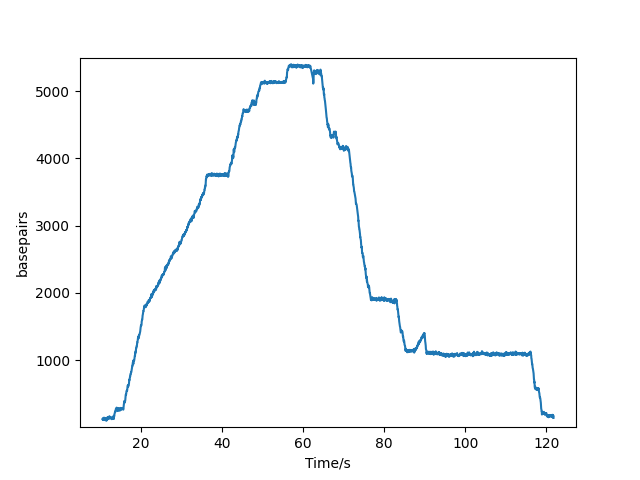

In [110]:
# to view the data
time = trace['time']/1000
time = time.dropna()
time = np.array(time)
bp = trace['basepairs']
bp = bp.dropna()
bp = np.array(bp)
bp = 8393 - bp

plt.figure()
plt.plot(time,bp)
plt.xlabel('Time/s')
plt.ylabel('basepairs')
plt.ylim(np.min(bp)-100,np.max(bp)+100)
plt.show()

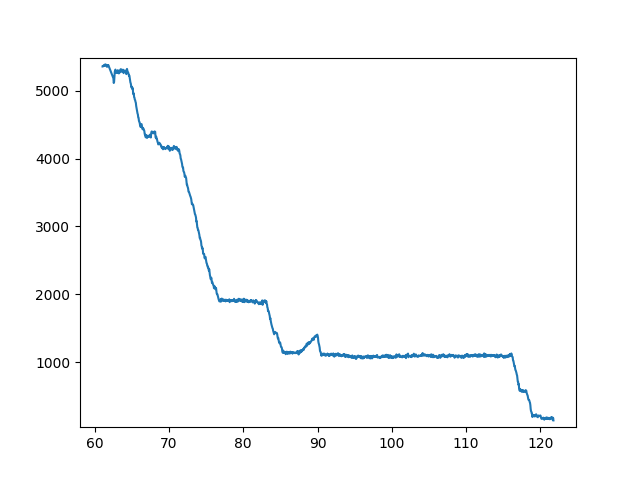

In [112]:
# Depending on whether there is a force transition from exo to pol, the following codes can be used to calculate the ROI of exo, pol or overall
force_transi_time = input('please type in the force transision time in s:(if not appliable, enter 0)' ) 
force_transi_time = float(force_transi_time)

try:
    index_exo = np.where(time < force_transi_time)
    time_exo = time[index_exo]
    bp_exo = bp[index_exo]
    
    index_pol = np.where(time > force_transi_time)
    time_pol = time[index_pol]
    bp_pol = bp[index_pol]
except KeyError:
    pass

# this code should be customerized based on the analysis: with time_exo for exo analysis, time_pol for pol analysis or time for overall analysis
time_ROI = time_pol
bp_ROI = bp_pol

plt.figure()
plt.plot(time_ROI,bp_ROI)
plt.ylim(np.min(bp_ROI)-100,np.max(bp_ROI)+100)
plt.show()

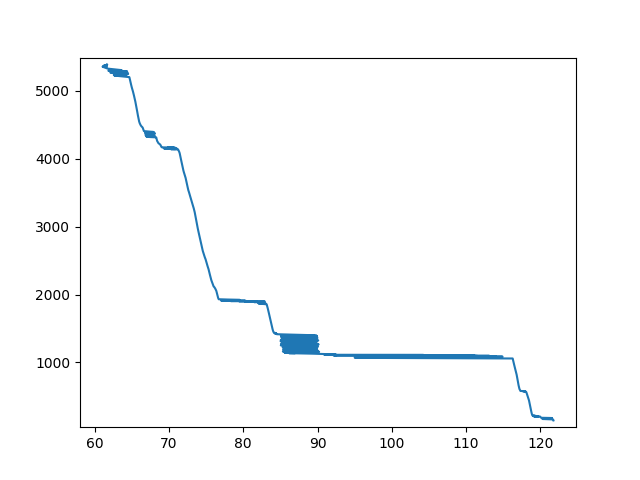

In [113]:
# This code block is intended to calculate the dwell time of protein at specific sequence
# setp1: after reducing the noise with sg_filter, the single-molecule trace is interpolated along y-axis to have one-bp window to calculate the corresponding dwell time
bp_ROI = savgol_filter(bp_ROI, 15, 3)
func = interpolate.interp1d(bp_ROI,time_ROI,kind='slinear',fill_value="extrapolate")
bp_interpolate = np.arange(int(np.min(bp_ROI)),int(np.max(bp_ROI)),1)
time_interpolate = func(bp_interpolate)
plt.figure()
plt.plot(time_interpolate,bp_interpolate)
plt.ylim(np.min(bp_ROI)-100,np.max(bp_ROI)+100)
plt.show()

[0.00319773 0.00319773 0.00319773 ... 0.00969273 0.00969273 0.00969273]
[121.76702529 121.76382756 121.76062983 ...  61.60817584  61.61786857
  61.62756129]


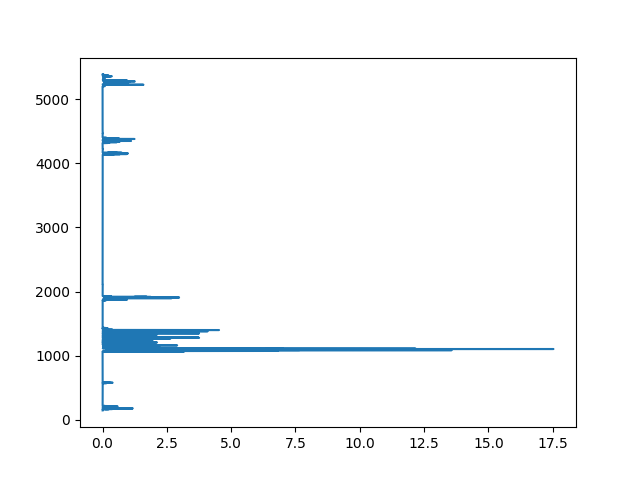

In [114]:
# This code block is intended to calculate the dwell time of protein at specific sequence
# setp2: calculate and plot the dwell time
dwell_time = np.diff(time_interpolate)
dwell_time = np.absolute(dwell_time)
print(dwell_time)
print(time_interpolate)
plt.figure()
plt.plot(dwell_time,bp_interpolate[:-1])
# plt.scatter(time_interpolate[:-1],dwell_time)
# plt.ylim(np.min(bp_ROI)-100,np.max(bp_ROI)+100)
plt.show()

   Unnamed: 0     time/s  binarized_intensity
0           0  10.660204                    0
1           1  10.873408                    0
2           2  11.086612                    0
3           3  11.299816                    0
4           4  11.513020                    0


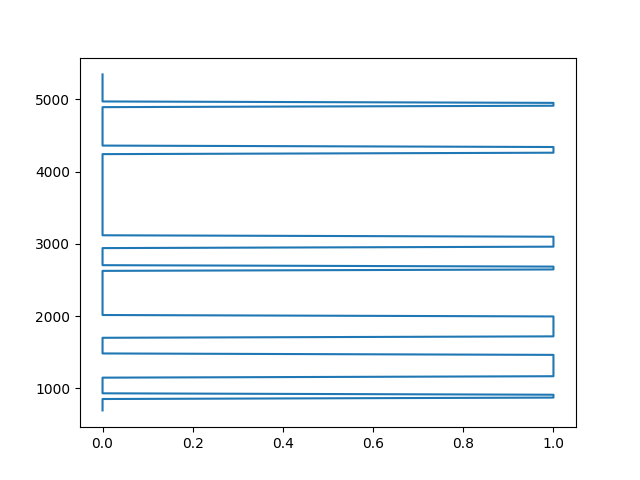

In [115]:
# read and plot the binarized intensity trace calculated from image data
# intens_name = input('please type in the file name:' ) + '.xlsx'
# intens_path = input('please type in the file path:')
# intens_file = os.path.join(intens_path, intens_name) 
# intens = pd.read_excel(intens_file,sheet_name = 'Sheet1')

time_intens = intens['time/s']
time_intens = np.array(time_intens)
intensity = intens['binarized_intensity']
intensity = np.array(intensity)
print(intens.head())

func2 = interpolate.interp1d(time_ROI,bp_ROI,kind='slinear',fill_value="extrapolate")
index2 = np.where(time_intens < force_transi_time)
time_intens = time_intens[index2]
intensity = intensity[index2]
bp_intensity = func2(time_intens)

plt.figure()
plt.plot(intensity,bp_intensity)
plt.show()

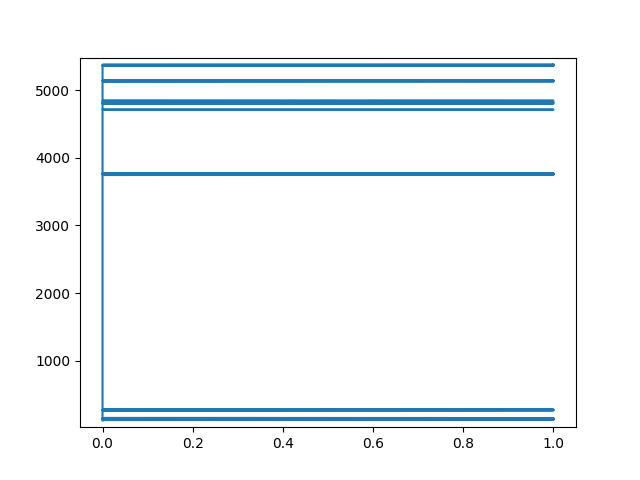

In [100]:
# Set a threshold (e.g.: 0.4), above which is regarded as a pause, otherwise as noise; This should be further discussed
threshold = 0.4
upper, lower = 1, 0
dwell_time_binarized = np.where(dwell_time>threshold, upper, lower)
plt.figure()
plt.plot(dwell_time_binarized,bp_interpolate[:-1])
plt.ylim(np.min(bp_ROI)-100,np.max(bp_ROI)+100)
plt.show()

In [116]:
# this is to find out the dissociation location by finding the intensity drops from 1 to 0
intensity_diff = np.diff(intensity)
ind = np.where(intensity_diff == -1)
unbound_pos = np.zeros(len(intensity_diff))
unbound_pos[ind] = 1

print(unbound_pos)
print(bp_intensity[ind])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 910.55797517 1462.72992481 1995.18144767 2685.3963847  3099.52534693
 4341.9122336  4953.24546355]


In [117]:
# this is to save all the pasue location and unbound protein location
# excel_filename = r'C:\Users\KTS260\Desktop\dwell_time_analysis_Mol.xlsx'

# writer = pd.ExcelWriter(excel_filename)
# data_1 = {'bp index':bp_interpolate[:-1],
#           'dwell time':dwell_time_binarized }
# df1 = pd.DataFrame(data_1)
# df1.to_excel(writer,sheet_name ='BinarizedDwellTime')
# data_2 = {'bp index':np.rint(bp_intensity[:-1]),
#           'unbound position':unbound_pos }
# df2 = pd.DataFrame(data_2)
# df2.to_excel(writer,sheet_name ='unbound Position')
# writer.save()

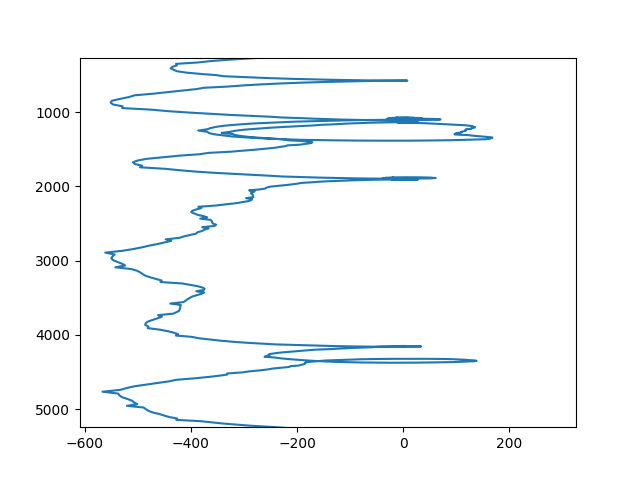

In [118]:
# to display the instantanous rate as a function of sequence index.
# fisrt, to reduce the noise
bp_filter = savgol_filter(bp_ROI, 35, 3)

rate = np.diff(bp_filter)/np.diff(time_ROI)
# print(rate)
# print(np.mean(np.diff(time_ROI)))
# print(np.diff(bp_ROI))
plt.figure()
plt.plot(rate,bp_filter[:-1])
plt.ylim(bp_filter[0]-100,bp_filter[-1]+100)
plt.show()

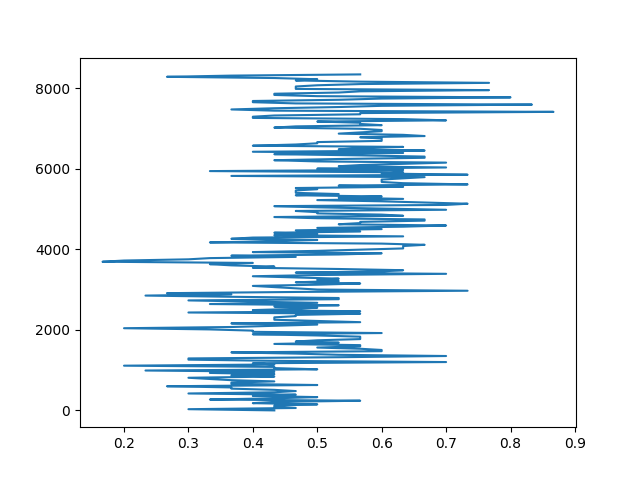

In [119]:
# this is used to calculate the GC content as a function of sequence index
# you should be very careful with the fragment length and starting data, as this will cause some difference

import re
# define the frament length within which you want to calculate the GC content
fragment_length = 30
# starting_data refers to the data index, which you want to assign your calculated GC content to (e.g.: 1, 45 or 90 in the case of fragment length is 90)
starting_data = 1

# read the raw sequence data of DNA construct
# file_sequence = open(r'C:\Users\KTS260\Desktop\DNAp_exo_sequence.txt')
file_sequence = open(r'/Users/longfu/Library/CloudStorage/Dropbox/3-T7 DNAp_Nat Com～working/Pre_ms/Sequence-dependance of proof-reading @50pN/DNAp_exo_sequence.txt')

file_sequence = file_sequence.read().splitlines()
file_sequence = ''.join(file_sequence)
file_sequence = file_sequence.replace(' ', '').replace('/r', '').replace('/n', '').replace('\t', '')

# define a function to cut the fragment to the designed length
def cut_text(text, lenth):
    textArr = re.findall('.{' + str(lenth) + '}', text)
    textArr.append(text[(len(textArr) * lenth):])
    return textArr
file_cut = cut_text(file_sequence, fragment_length)

# calculate the GC content
GC_ratio_array = []
for i in np.arange(len(file_cut)):
    GC_num = file_cut[i].count('G') + file_cut[i].count('C')
    GC_ratio = GC_num / fragment_length
    GC_ratio_array.append(GC_ratio)

# to list the sequence from 0 to the end of the DNA construct
sequence_index = np.arange(starting_data,len(file_sequence),fragment_length)

plt.figure()
plt.plot(GC_ratio_array,sequence_index)
plt.show()

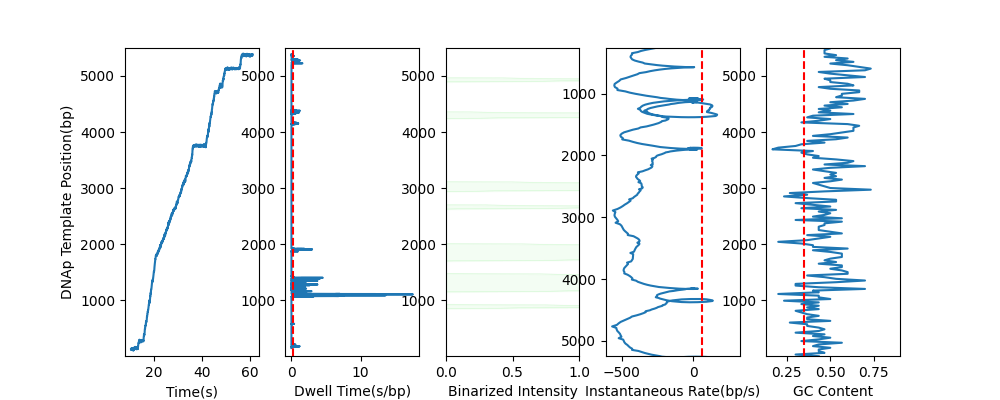

In [120]:
plt.figure(figsize = (10,4))

plt.subplot(1, 5, 1)
plt.plot(time_exo,bp_exo)
plt.ylim(np.min(bp_exo)-100,np.max(bp_exo)+100)
plt.xlabel('Time(s)')
plt.ylabel('DNAp Template Position(bp)')

plt.subplot(1, 5, 2)
plt.plot(dwell_time,bp_interpolate[:-1])
plt.ylim(np.min(bp_exo)-100,np.max(bp_exo)+100)
plt.axvline(0.3, color='r', linestyle='--')
plt.xlabel('Dwell Time(s/bp)')
# plt.ylabel('DNAp Template Position(bp)')

plt.subplot(1, 5, 3)
plt.xlabel('Binarized Intensity')
# plt.ylabel('DNAp Template Position(bp)')
plt.plot(intensity,bp_intensity,"lightgreen",linewidth = 0.1)
plt.fill_between(intensity,bp_intensity,0, color='lightgreen',alpha=0.1)
plt.ylim(np.min(bp_exo)-100,np.max(bp_exo)+100)
plt.xlim(0,1)

plt.subplot(1, 5, 4)
plt.plot(rate,bp_filter[:-1])
plt.ylim(bp_filter[0]-100,bp_filter[-1]+100)
plt.axvline(60, color='r', linestyle='--')
plt.xlabel('Instantaneous Rate(bp/s)')
# plt.ylabel('DNAp Template Position(bp)')

plt.subplot(1, 5, 5)
plt.xlabel('GC Content')
# plt.ylabel('DNAp Template Position(bp)')
plt.plot(GC_ratio_array,sequence_index)
plt.ylim(np.min(bp_exo)-100,np.max(bp_exo)+100)
plt.axvline(0.35, color='r', linestyle='--')

plt.show()
plt.tight_layout()

# plt.savefig(cor_name.replace('-correlated_data.xlsx', '-dwellTime_BinarizedIntensity_rate_GCContent-pol.eps'), format='eps', dpi=300,bbox_inches='tight')

In [121]:
# this data block is used to save the dwell time as a window size, which can be further analyzed with FPT
# excel_filename = r'C:\Users\KTS260\Desktop\pause_sequence_analysis.xlsx'

# writer = pd.ExcelWriter(excel_filename)
# data_1 = {'bp index':bp_interpolate[:-1],
#           'dwell time':dwell_time }
# df1 = pd.DataFrame(data_1)
# df1.to_excel(writer)
# writer.save()

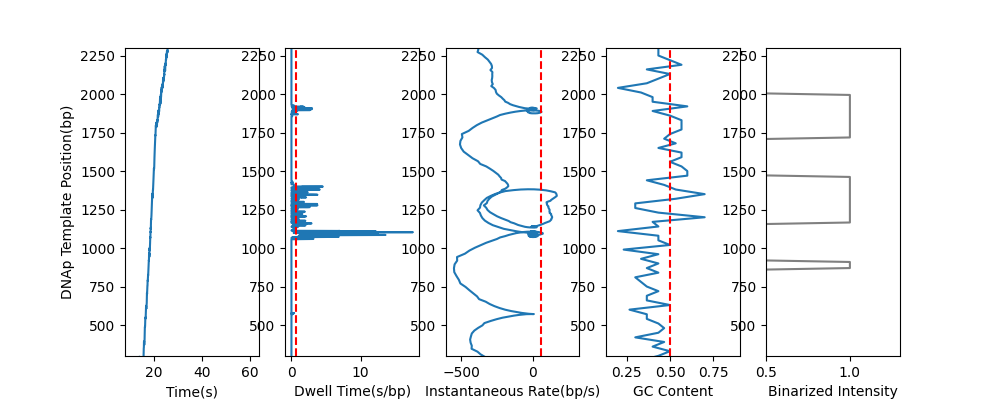

In [122]:
plt.figure(figsize = (10,4))

plt.subplot(1, 5, 1)
plt.plot(time_exo,bp_exo)
plt.ylim(300,2300)
plt.xlabel('Time(s)')
plt.ylabel('DNAp Template Position(bp)')

plt.subplot(1, 5, 2)
plt.plot(dwell_time,bp_interpolate[:-1])
plt.ylim(300,2300)
plt.axvline(0.6, color='r', linestyle='--')
plt.xlabel('Dwell Time(s/bp)')
# plt.ylabel('DNAp Template Position(bp)')

plt.subplot(1, 5, 3)
plt.plot(rate,bp_filter[:-1])
plt.ylim(300,2300)
plt.axvline(60, color='r', linestyle='--')
plt.xlabel('Instantaneous Rate(bp/s)')
# plt.ylabel('DNAp Template Position(bp)')

plt.subplot(1, 5, 4)
plt.xlabel('GC Content')
# plt.ylabel('DNAp Template Position(bp)')
plt.plot(GC_ratio_array,sequence_index)
plt.ylim(300,2300)
plt.axvline(0.5, color='r', linestyle='--')

plt.subplot(1, 5, 5)
plt.xlabel('Binarized Intensity')
# plt.ylabel('DNAp Template Position(bp)')
plt.plot(intensity,bp_intensity,"gray")
plt.ylim(300,2300)
plt.xlim(0.5,1.3)

plt.show()
plt.tight_layout()

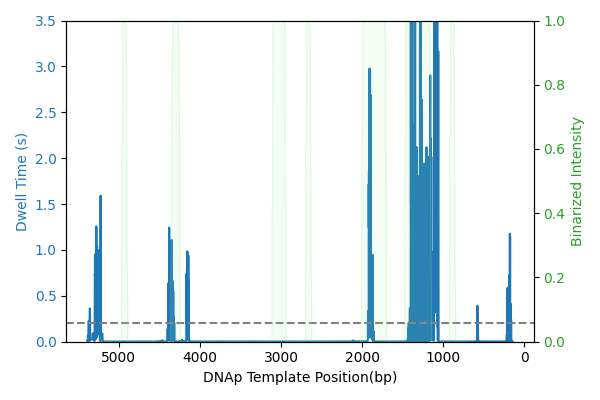

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [132]:
# to analyze the data from the sequence side
fig, ax1 = plt.subplots(figsize = (6,4))

color = 'tab:blue'
ax1.set_xlabel('DNAp Template Position(bp)')
ax1.set_ylabel('Dwell Time (s)', color=color)
ax1.set_ylim(0,3.5)
ax1.plot(bp_interpolate[:-1], dwell_time,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.2, color='gray', linestyle='--')
ax1.invert_xaxis()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Binarized Intensity', color=color)  # we already handled the x-label with ax1
ax2.plot(bp_intensity, intensity,color="lightgreen",linewidth = 0.1)
ax2.fill_between(bp_intensity,intensity, 0, color='lightgreen',alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)


# plt.xlim(0,400)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig(cor_name.replace('-correlated_data.xlsx', '-dwellTime_BinarizedIntensity_DNAIndex-pol.eps'), format='eps', dpi=300,bbox_inches='tight')

-0.28177908215892716
2.0890890956644307e-25


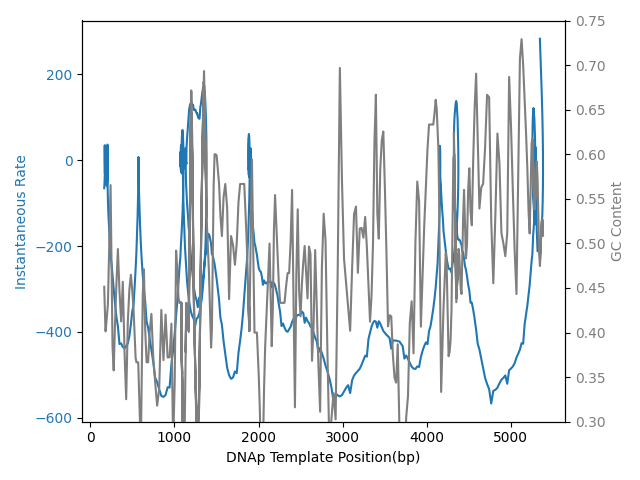

In [124]:
# To calculate the corelation between instantanous rate and GC content
from scipy import stats
func3 = interpolate.interp1d(sequence_index,GC_ratio_array,kind='slinear',fill_value="extrapolate")
GC_ratio_array_interpolate = func3(bp_filter[:-1])

cor_coef,p_value = stats.pearsonr(GC_ratio_array_interpolate ,rate)
print(cor_coef)
print(p_value)


fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('DNAp Template Position(bp)')
ax1.set_ylabel('Instantaneous Rate', color=color)
# ax1.set_ylim(0,3)
ax1.plot(bp_filter[:-1], rate,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:gray'
ax2.set_ylabel('GC Content', color=color)  # we already handled the x-label with ax1
ax2.plot(bp_filter[:-1], GC_ratio_array_interpolate,color=color,label="correlation coefficient=" + str('%.2f'%cor_coef) )
# ax2.plot(sequence_index, GC_ratio_array,color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.3,0.75)
# plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

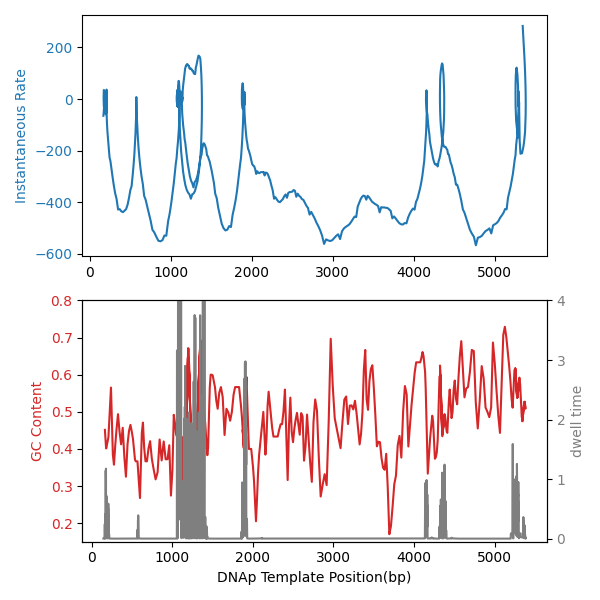

In [125]:
# To calculate the corelation between instantanous rate and GC content
fig, (ax1, ax3) = plt.subplots(2,1, figsize=(6,6))

color = 'tab:blue'
ax1.set_ylabel('Instantaneous Rate', color=color)
# ax1.set_ylim(0,3)
ax1.plot(bp_filter[:-1], rate,color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax3.set_ylabel('GC Content', color=color)  # we already handled the x-label with ax1
ax3.plot(bp_filter[:-1], GC_ratio_array_interpolate,color=color,label="correlation coefficient=" + str('%.2f'%cor_coef) )
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(0.15,0.8)
ax3.set_xlabel('DNAp Template Position(bp)')

ax2 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax2.set_ylabel('dwell time', color=color)  # we already handled the x-label with ax1
ax2.plot(bp_interpolate[:-1], dwell_time,color=color)
# ax2.plot(sequence_index, GC_ratio_array,color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.05,4)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig(cor_name.replace('-correlated_data.xlsx', '-rate_GCContent.eps'), format='eps', dpi=300,bbox_inches='tight')

In [126]:
# this code block is used to analyze the Correlation between pausing and protein dissociation
excel_filename = r'/Users/longfu/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/0-DNAp_project_updated_jan2022/Data_Analysis_Exploration/all_5_mol.xlsx'
pause = pd.read_excel(excel_filename, sheet_name = "pause")
unbound = pd.read_excel(excel_filename, sheet_name = "unbound")
# print(pause.head())
# print(unbound.head())
bp_index = pause['bp_index']
pause_prob = pause['probablity']
unbound_loc = unbound['unbound_position'].fillna(0)
# print(bp_index)
# print(pause_prob)
# print(unbound_loc)

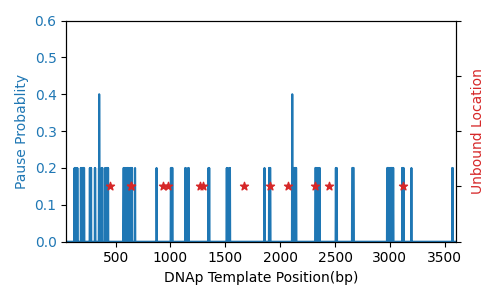

In [127]:
# this code block is used to analyze the Correlation between pausing and protein dissociation
fig, ax1 = plt.subplots(figsize = (5,3))

color = 'tab:blue'
ax1.set_xlabel('DNAp Template Position(bp)')
ax1.set_ylabel('Pause Probablity', color=color)
ax1.set_ylim(0,0.6)
ax1.plot(bp_index, pause_prob,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Unbound Location', color=color)  # we already handled the x-label with ax1
ax2.scatter(bp_index, unbound_loc,color=color,marker = '*')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.9,1.3)
ax2.yaxis.set_ticklabels([])

plt.xlim(50,3600)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

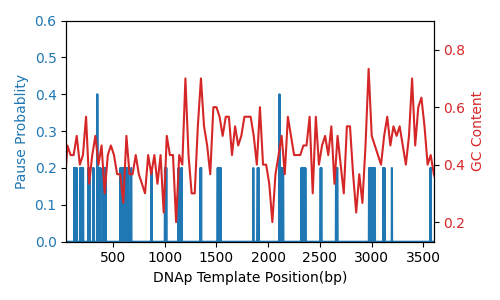

In [128]:
# This is used to analyze the correlation between Pause probablity and GC content 
fig, ax1 = plt.subplots(figsize = (5,3))

color = 'tab:blue'
ax1.set_xlabel('DNAp Template Position(bp)')
ax1.set_ylabel('Pause Probablity', color=color)
ax1.set_ylim(0,0.6)
ax1.plot(bp_index, pause_prob,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('GC Content', color=color)  # we already handled the x-label with ax1
ax2.plot(sequence_index, GC_ratio_array,color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(0.9,1.3)
# ax2.yaxis.set_ticklabels([])

plt.xlim(50,3600)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()